<a href="https://colab.research.google.com/github/MarshaGomez/F5-MOEA-Variations/blob/main/examples/Single_Objective_Brachistochrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Single Objective. Brachistochrone Problem


The Brachistochone is the famous problem to find the shape of the curve down wich a bead sliding from rest and accelerated by gravity will slip (**without friction**) from one point to another in the least time. 

"The shortest path and the shortest time"

## Base Operations

### Necessary libraries

In [35]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [36]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as mplcm
import matplotlib.colors as colors
import random as rm
import os
import subprocess
import torch
import sys
import torch.optim as optim
import glob
import time

from pathlib import Path
from PIL import Image, ImageSequence
from time import sleep
from datetime import datetime, date
from math import sqrt,sin,cos, floor
from scipy.optimize import fsolve
from random import shuffle, randint, sample
from copy import deepcopy

### Global Values

In [37]:
base_path = "/content/gdrive/My Drive/Brachistochrone/MOEA Project/Single-Objective"
counter = 0

date_string = date.today()
base_name = f'GD_Brach__{date_string}'
gif_dir = os.path.join(base_path, "gifs/" + base_name)
misc_runs_dir = os.path.join(base_path, "misc_runs/" + base_name)

Path(gif_dir).mkdir(parents=True, exist_ok=True)
Path(misc_runs_dir).mkdir(parents=True, exist_ok=True)

### Hyperparameters

In [38]:
objectives = ["Short Time"]
n_dimensions = 1
n_iterations = 200
n_individuals = 40
n_generations = 10000
n_points = 30

# Probabilities
ps = 0.2 # selection
pc = 1 # crossover
pm = 0.1 # mutation Change less mutation

elitismo = 0.1 

p_variable = True # Varied the probability


# Boundaries 
xl = 0 # left boundary
xr = 1 # rigth boundary
yu = 1 # up boundary
yl = -1 # low boundary
limits = [xl, yl]
weights = [0.1, 0.1]
height = 1
width = 1

seed = 1

show_info = False # See Description Prints
show_plot = True # See Description Prints
save_gif = True # Save gif image
frames_gif = 100
parents = []
new_individuals = []

### Common Functions

In [39]:
def normalize(data, min, max):
  normal = []
  old_min = np.min(data)
  old_max = np.max(data)
  old_range = old_max - old_min
  
  new_min = min
  new_max = max
  new_range = new_max - new_min

  if old_range == 0:            
      if old_min < new_min:      
          new_value = new_min
      elif old_min > new_max:    
          new_value = new_max
      else:                    
          new_value = old_min
      normal = [new_value for value in data]
  else:
      scale = new_range / old_range
      normal = [(value - old_min) * scale + new_min for value in data]

  return normal

def makeImage(fp_in, fp_out):
  global counter
  counter += 1
  imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
  img = next(imgs)  # extract first image from iterator
  img.save(fp=fp_out, format='GIF', append_images=imgs,
          save_all=True, duration=400, loop=0)
  
  img = Image.open(fp_out)
  
def showGif(fname):
    import base64
    from IPython import display
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

def fitnessFunction(y_no_end_pts, height):
    g = 9.8
    n_segments = len(y_no_end_pts) + 1
    width = 1.0
    delta_x = width/n_segments
    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)

    y = torch.cat((torch.tensor([height]), y_no_end_pts, torch.tensor([0.0])), dim=0)

    d = torch.stack([-(y[i+1] - y[i]) for i in range(n_segments)])

    temp = torch.stack([torch.tensor(0.0)] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = sqrt(2*g)*torch.sqrt(temp)

    v = v[:-1]
    t = (torch.sqrt(v**2 + 2*g*d) - v)/(g*d/torch.sqrt(d**2 + delta_x**2))

    return(sum(t))



## Genetic Algorithm Components



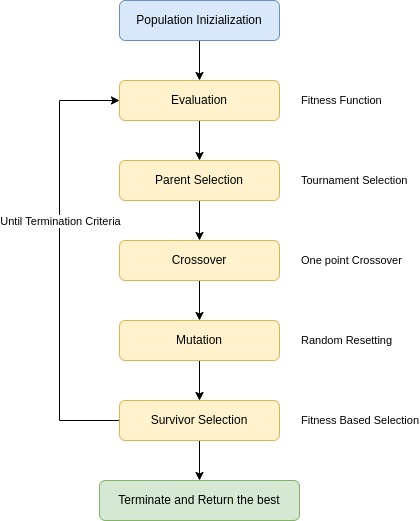

### Initialization


#### Individual

Creating Random Individual

In [40]:
class Individual():

  def __init__(self, n_points=n_points, height=height, **kwargs):
    self.n_segments = n_points
    self.n_points = n_points+1
    self.width = 1.0
    self.height = height
    self.y = [self.height]
    self.x = [0]
    self.delta_x = self.width/self.n_segments

    for i in range(self.n_segments-1):
        self.x.append((i+1)*self.delta_x)
        frac = 1
        self.y.append(-self.height/frac + rm.random()*(self.height - (-self.height/frac)))

    self.x.append(1.0)
    self.y.append(0)

    self.sol = None

    #This is just assuming it dropping vertically and then going horizonally at that speed
    g = 9.8
    t1 = sqrt(2*self.height/g)
    v1 = g*t1
    t2 = self.width/v1
    self.max_FF = 40*(t1 + t2)

#### Population

Creating a Population with n-random Individuals

In [41]:
class Population():
  
  def __init__(self, individual_class=Individual, n_individuals=n_individuals, **kwargs):
    self.kwargs_str = '__'.join(['{}={}'.format(x[0], x[1]) for x in kwargs.items()])
    print(self.kwargs_str)

    self.individual_class = individual_class
    self.class_name = individual_class.__name__
    self.n_individuals = n_individuals
    self.population = [[self.createNewIndivid(**kwargs), 0] for i in range(self.n_individuals)]
    self.sorted_population = None

    if show_plot:
      self.plotPopulation()

    if show_info:
      self.printPopulation()

  def createNewIndivid(self, **kwargs):
    return(self.individual_class(**kwargs))

  def printPopulation(self):
    print("Population Edited Parameters: ")
    print(self.kwargs_str)
    print("--------------------------------")

  def plotPopulation(self,  **kwargs):
    print("Population Diagram: ")
    print("--------------------------------")
    # plot lines
    for individual in self.population:
      plt.plot(individual[0].x, individual[0].y)
    plt.show()


  

### Evaluation

In [44]:
class Fitness():

  global show_info

  def __init__(self, population=Population, **kwargs):
    self.population = deepcopy(population)

  '''
  def __del__(self):
    del self.population
    # print("Destructor called")
  '''

  def getBestCurve(self, individual):
    w = individual.width
    h = individual.height

    #The coords we've been using (dropped at (0,h), ending at (w,0)), simply add h to y in the end.

    f_t = lambda t: np.cos(t)-1+ (-h/w)*(np.sin(t)-t)
    t = fsolve(f_t,3.14)[0]

    a = w/(t-sin(t))

    t_range = np.linspace(0,t,individual.n_points)

    x = lambda t: a*(t-np.sin(t))
    y = lambda t: h + a*(np.cos(t)-1)

    self.sol = (t_range, x, y)

    sol_numeric_y = []

    for x_pt in individual.x:
        f = lambda t: x(t)-x_pt
        tval = fsolve(f,3.14)[0]
        sol_numeric_y.append(y(tval))

    temp_state = individual.y
    individual.y = sol_numeric_y
    individual.sol_numeric_y = sol_numeric_y
    
    self.t_ideal = self.getFitness(individual)
    individual.y = temp_state

    if show_info:
      print('\n-------------------------------------')
      print('Theoretical best time:', self.t_ideal, "\n")

  def getFitness(self, individual):
    g = 9.8

    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
    d = -np.array([individual.y[i+1] - individual.y[i] for i in range(individual.n_segments)])

    #Be careful with signs and indices!
    v = sqrt(2*g)*np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])

    if np.isnan(v).any():
      print('\n\nbad v:',v)
      print('\nbad d sum:',[sum(d[:(i+1)]) for i in range(len(d))])
      print('\nstate', individual.y)
      plt.savefig('test_bad_np.png')
      exit(0)


    #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = v[:-1]
    t = (np.sqrt(v**2 + 2*g*d) - v)/(g*d/np.sqrt(d**2 + individual.delta_x**2))

    F1 = (sum(t))
    return F1

  def getFitnessPopulation(self, sort=False):
    for individual in self.population.population:
      individual[1] = self.getFitness(individual[0])

    if sort:
      self.sortIndividuals()

    if show_info:
      self.printFitnessFunctions()

    return self.population

  def sortIndividuals(self):
    list.sort(self.population.population, key=lambda fitness: fitness[1])

  def printFitnessFunctions(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.population):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def plotState(self, individual, ax, width, height, color='black', plot_sol=False, plot_label=False):
    # Pass this an axis from another program. It will handle showing it and stuff.
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_title('Comparison Actual Result with Brachistochrone')

    if plot_sol:
      t = self.sol[0]
      x = self.sol[1]
      y = self.sol[2]
      ax.plot(x(t), y(t), '-', color='gray')

      if plot_label:
        ax.text(0.8*width, 0.9*height, 'ideal: {:.3f}'.format(self.t_ideal))

    if plot_label:
      ax.text(0.8*width, 0.8*height, 'cur. best: {:.3f}'.format(self.getFitness(individual)))

    ax.plot(individual.x, individual.y, 'o-', color=color)


  def plotFitnessFunction(self, ax, best, mean):
    ax.clear()
    ax.set_xlabel('Generations')
    ax.set_ylabel('Fitness Function')
    ax.set_title('Best and Mean Results')

    ax.plot(best, label='best', color='dodgerblue')
    ax.plot(mean, label='mean', color='tomato')
    ax.legend()
    ax.text(0.6*len(best), 0.8*max(best), 'best: {:.3f}\nmean: {:.3f}'.format(best[-1], mean[-1]))


### Selection

In [45]:
class Selection():
  
  def __init__(self, population=Population, ps=ps, **kwargs):
    self.population = population
    self.parents = []
    self.ps = ps
    self.quantity_parents = 3

  '''
  def __del__(self):
    del self.population
    del self.parents

   #    print("Destructor called")
  '''

  # Probabilistic Selection
  def getProbabilisticSelection(self):
    probability = np.random.uniform(
        low=0, high=1, size=self.population.n_individuals)
    
    probability = probability < self.ps
    if sum(probability == True) > 0:
      self.quantity_parents = sum(probability == True)

  def getParentsSelection(self):
    self.getProbabilisticSelection()
    for i in range(self.quantity_parents):
      self.parents.append(self.tournamentSelection())

    # self.parents = np.unique(self.parents, axis=0)

    if show_info:
      self.printParents()

    return self.parents

  def tournamentSelection(self):
    parents = rm.choices(self.population.population, k=5)
    list.sort(parents, key=lambda fitness: fitness[1])

    return (parents[0])

  def printParents(self):
    print('\n-------------------------------------')
    print('Selection Parents')
    print('\n')
    for index, individual in enumerate(self.parents):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))

  def isSameState(self, other_state):
    max_diff = ((self.n_points-2)*self.height)**2
    diff = (np.array(self.y) - np.array(other_state.y))[1:-1]
    abs_diff_normed = abs(sum(diff))/(self.n_points-2)
    
    if abs_diff_normed < self.sameness_thresh:
      return(True)
    else:
      return(False)

  def deleteDuplicates(self,pop):
    unique_individuals = []
    no_duplicates = []
    
    for index,individual in enumerate(pop):
      is_not_unique = np.any([individual.isSameState(other) for other in no_duplicates])
      if not is_not_unique:
        unique_individuals.append(individual.y)
        no_duplicates.append(individual)

    return(no_duplicates)

### Crossover

In [46]:
class Crossover():
  
  def __init__(self, population=Population, parents=parents, pc=pc, **kwargs):
    self.population = population
    self.parents = parents
    self.new_individuals = []
    self.pc = pc

  '''
  def __del__(self):
    del self.population
    del self.parents
    del self.new_individuals

    #print("Destructor called")
  '''

  def getNewIndividuals(self):
    rm.shuffle(self.parents)
    n_couple = int((len(self.parents)-1) / 2)
    for i in range(n_couple+1):
      new_child1, new_child2 = self.onePointCrossover(self.parents[i], self.parents[-i-1])
      self.new_individuals.append(new_child1)
      self.new_individuals.append(new_child2)

    if show_info:
      self.printNewPopulation()

    return self.new_individuals

  def onePointCrossover(self, parent1, parent2):
    new_child1 = deepcopy(parent1)
    new_child2 = deepcopy(parent2)

    r1 = randint(1,parent1[0].n_points-3)
    r2 = randint(r1+1,parent2[0].n_points-2)

    temp = new_child1[0].y[r1:r2]
    new_child1[0].y[r1:r2] = new_child2[0].y[r1:r2]
    new_child2[0].y[r1:r2] = temp

    return(new_child1, new_child2)


  def printNewPopulation(self):
    print('\n-------------------------------------')
    print('Crossover New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')


  def mateAvg(self,other_individ):
    newindivid_1 = deepcopy(self)
    newindivid_2 = deepcopy(other_individ)

    newindivid_1.y = ((np.array(newindivid_1.y) + np.array(newindivid_2.y))/2).tolist()

    return(newindivid_1,newindivid_1)

### Mutation

In [47]:
class Mutation():

  def __init__(self, new_individuals=new_individuals, pm=pm, **kwargs):
    self.new_individuals = new_individuals
    self.pm = pm

  '''
  def __del__(self):
    del self.new_individuals

    # print("Destructor called")
  '''

  def randomSetMutation(self):
    mutate_individual = []
    mutate_individual.clear()

    for individual in self.new_individuals:
      mutate_individual.append(self.mutate(individual))

    self.new_individuals = mutate_individual
      
    if show_info:
      self.printMutation()

    return self.new_individuals

  def mutate(self, individual):
    probability = np.random.uniform(
    low=0, high=1, size=individual[0].n_points-2)

    probability = probability <= pm

    mutate_individual = deepcopy(individual)
    height = individual[0].height
  
    if sum(probability == True) > 0:
      mutate_individual[0].y = mutate_individual[0].y[1: mutate_individual[0].n_points-1]

      # Muta Random Process
      for i in np.where(probability)[0]:
        frac = 2
        mutate_individual[0].y[i] = (-height/frac + rm.random()*(height - (-height/frac)))
      
      mutate_individual[0].y = [height] + mutate_individual[0].y + [0]

    return mutate_individual 

  def printMutation(self):
    print('\n-------------------------------------')
    print('Mutation New Individuals')
    print('\n')
    for index, individual in enumerate(self.new_individuals):
      print('Individual {:10}     |    Individual Y:'.format(index), *individual[0].y, sep=', ')

  def mutateSingle(self):
    index = randint(1, self.n_segments-1)
    new_height = self.y[index] + np.random.normal(scale=self.mutate_strength)
    
    if new_height < self.height:
      self.y[index] = new_height

### Survivor Selection

In [48]:
class Survivor_Selection():
  def __init__(self, population=Population, new_individuals=new_individuals, **kwargs):
    self.population = population
    self.new_individuals = new_individuals
    self.new_population = []

  '''
  def __del__(self):
    del self.population 
    del self.new_individuals 
    del self.new_population
    # print("Destructor called")
  '''

  def getNewPopulation(self):
    
    for individual in self.new_individuals:
      individual[1] = self.getFitness(individual[0])

    self.new_population = self.population.population + self.new_individuals

    list.sort(self.new_population, key=lambda fitness: fitness[1])
    
    self.new_population = self.new_population[: self.population.n_individuals]
    self.population.population = self.new_population

    self.best, self.mean = self.getBestandMean()

    if show_info:
      self.printSurvivor()

    return self.population

  def getFitness(self, individual):
    g = 9.8

    #So if the next point is lower than the previous one, d will be *positive* (i.e., the y axis is down, opposite with the plot axis.)
    d = -np.array([individual.y[i+1] - individual.y[i] for i in range(individual.n_segments)])

    #Be careful with signs and indices!
    v = sqrt(2*g)*np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])

    if np.isnan(v).any():
      print('\n\nbad v:',v)
      print('\nbad d sum:',[sum(d[:(i+1)]) for i in range(len(d))])
      print('\nstate', individual.y)
      plt.savefig('test_bad_np.png')
      exit(0)


    #v = np.sqrt([0] + [sum(d[:(i+1)]) for i in range(len(d))])
    v = v[:-1]
    t = (np.sqrt(v**2 + 2*g*d) - v)/(g*d/np.sqrt(d**2 + individual.delta_x**2))

    F1 = (sum(t))
    return F1

  def getBestandMean(self):
    best = self.population.population[0][1]
    mean = sum([individual[1] for individual in self.population.population])/(1.0*len(self.population.population))
    return((best,mean))

  def printSurvivor(self):
    print('\n-------------------------------------')
    print('Objective Fitness 1: ', objectives[0])
    print('\n')
    for index, individual in enumerate(self.population.population):
      print('Individual {:10}     |    Fitness: {:.4f}'.format(index, individual[1]))



## Genetic Algorithm execution

In [51]:
class GeneticAlgorithm():

  # Variable = Variation of the Probability between epochs
  def __init__(self, population=Population, generations=n_generations, ps=ps, pc=pc, pm=pm):
    self.n_generations = n_generations 
    self.p_variable = p_variable
    self.population = population
    self.parents = []
    self.new_individuals = []

    best = []
    mean = []

    start = time.time()

    for i in range(self.n_generations):

      fitness = Fitness(self.population)
      self.population = fitness.getFitnessPopulation()

      selection = Selection(self.population, ps)
      self.parents = selection.getParentsSelection()

      crossover = Crossover(self.population, self.parents, pc)
      self.new_individuals = crossover.getNewIndividuals()

      mutation = Mutation(self.new_individuals, pm)
      self.new_individuals = mutation.randomSetMutation()

      survivor_selection = Survivor_Selection(self.population, self.new_individuals)
      self.population = survivor_selection.getNewPopulation()


      if i%max(1, int(self.n_generations/20.0))==0:
          self.population.plotPopulation()
          print('Generation {}, current best = {:.3f}, current population size = {}'.format(i, survivor_selection.best, len(self.population.population)))


      if show_plot:
        best.append(survivor_selection.best)
        mean.append(survivor_selection.mean)

        

    
    '''
    if show_plot:
      NUM_COLORS = n_individuals + 2
      cm = plt.get_cmap('RdBu')
      cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
      scalar_map = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
      pop_plot_color_list = [scalar_map.to_rgba(i) for i in range(NUM_COLORS)][::-1]

      self.population.plotPopulation()

    '''    
    
    self.population.plotPopulation()
    print('Generation {}, current best = {:.3f}, current population size = {}'.format(i, survivor_selection.best, len(self.population.population)))

    fig, axes = plt.subplots(2,1,figsize=(6,8))
    ax_FF = axes[0]
    ax_state = axes[1]

    cur_best, cur_mean = 0, 0

    fitness.plotFitnessFunction(ax_FF, best, mean)
    fitness.plotState(ax_state, color='black', plot_sol=True, plot_label=True)

    end = time.time()

    if show_info:
      print("\n-------------------------------------------")
      print("Process Complete ")
      print("\n")
      print("Time Process: {:20}".format(str(end - start)))
      print("\n-------------------------------------------\n")

    
    

# Test Section

## Individual Random Generation

In [ ]:
'''
population = Population(Individual, n_individuals=10, n_points=n_points, height=height)
individual = population.population[0][0]

fitness = Fitness(population)
fitness.getBestCurve(individual)


y = torch.tensor(individual.y[1:-1], requires_grad=True)

adam_optimizer = optim.RMSprop([y])

best = []
mean = []

for t in range(n_generations):

    J = fitnessFunction(y, height)

    best.append(J.item())
    mean.append(np.mean(best))

    individual.y[1:-1] = y.detach().tolist()

    if save_gif:
        if t==0 or (t%max(1, int(n_generations/frames_gif))==0):
            plt.savefig(f'{gif_dir}/{t+1}.png')

    if show_info:
      if t%int(n_generations/20)==0:
        print('iteration {:10}     |    loss: {:.4f}'.format(t, J.item()))

  
    adam_optimizer.zero_grad()
    J.backward()
    adam_optimizer.step()


plt.savefig(f'{misc_runs_dir}.png')


if show_plot:
  print('\n-------------------------------------')

  fig, axes = plt.subplots(2,1,figsize=(6,8))
  plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
  ax_FF = axes[0]
  ax_state = axes[1]
  fitness.plotFitnessFunction(ax_FF, best, mean)
  fitness.plotState(individual, ax_state, width, height, color='tomato', plot_sol=True, plot_label=True)

  fig.canvas.draw()


if save_gif:
    fp_in = gif_dir + "/*.png"
    fp_out = gif_dir + f'/image{counter+1}.gif'
    makeImage(fp_in, fp_out)

'''

## Population Random Generation

n_points=30__height=1
Population Diagram: 
--------------------------------


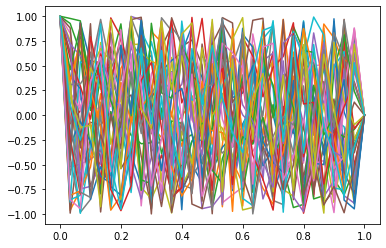

Population Diagram: 
--------------------------------


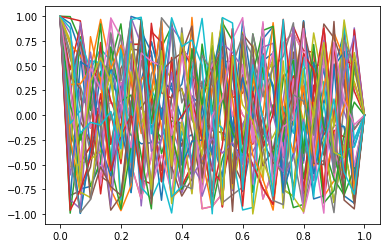

Generation 0, current best = 3.616, current population size = 40
Population Diagram: 
--------------------------------


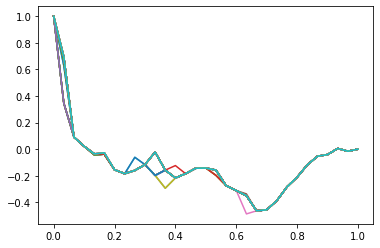

Generation 500, current best = 0.807, current population size = 40
Population Diagram: 
--------------------------------


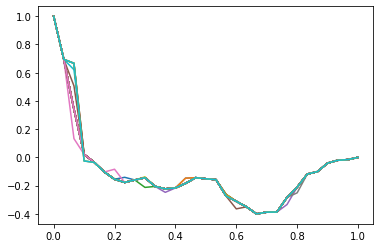

Generation 1000, current best = 0.756, current population size = 40
Population Diagram: 
--------------------------------


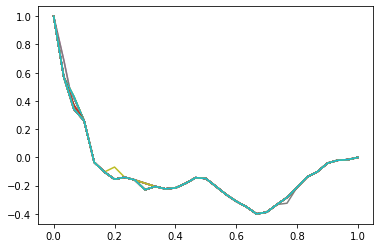

Generation 1500, current best = 0.742, current population size = 40
Population Diagram: 
--------------------------------


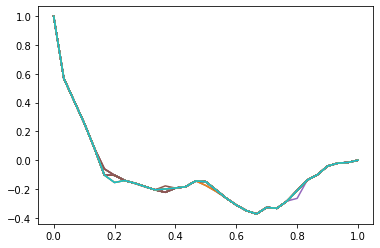

Generation 2000, current best = 0.728, current population size = 40
Population Diagram: 
--------------------------------


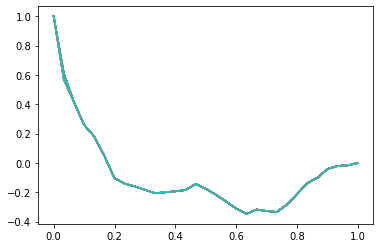

Generation 2500, current best = 0.720, current population size = 40
Population Diagram: 
--------------------------------


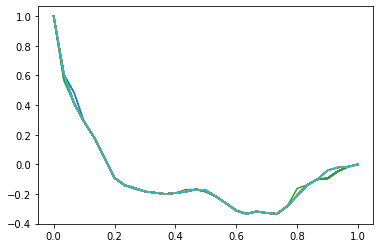

Generation 3000, current best = 0.707, current population size = 40
Population Diagram: 
--------------------------------


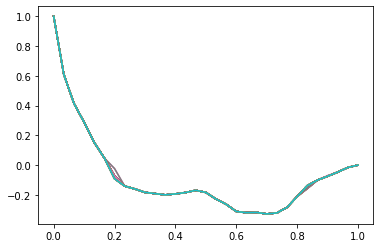

Generation 3500, current best = 0.701, current population size = 40
Population Diagram: 
--------------------------------


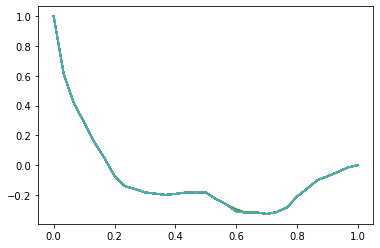

Generation 4000, current best = 0.698, current population size = 40
Population Diagram: 
--------------------------------


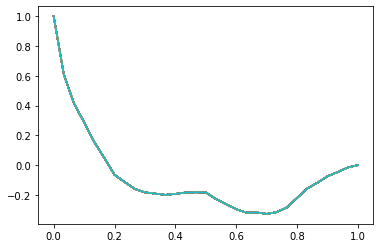

Generation 4500, current best = 0.696, current population size = 40
Population Diagram: 
--------------------------------


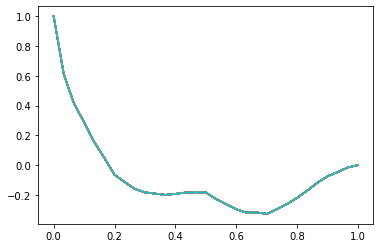

Generation 5000, current best = 0.695, current population size = 40
Population Diagram: 
--------------------------------


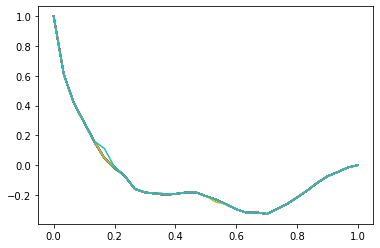

Generation 5500, current best = 0.692, current population size = 40
Population Diagram: 
--------------------------------


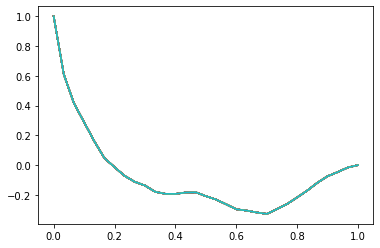

Generation 6000, current best = 0.688, current population size = 40
Population Diagram: 
--------------------------------


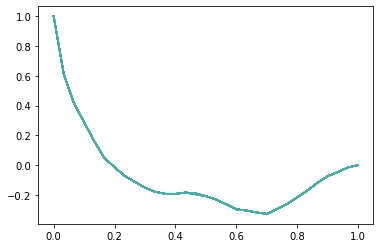

Generation 6500, current best = 0.687, current population size = 40
Population Diagram: 
--------------------------------


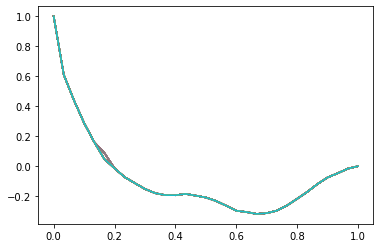

Generation 7000, current best = 0.685, current population size = 40
Population Diagram: 
--------------------------------


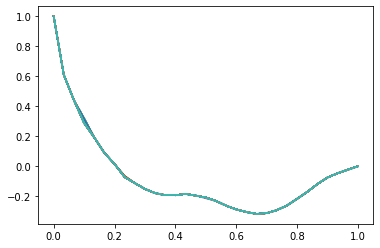

Generation 7500, current best = 0.683, current population size = 40
Population Diagram: 
--------------------------------


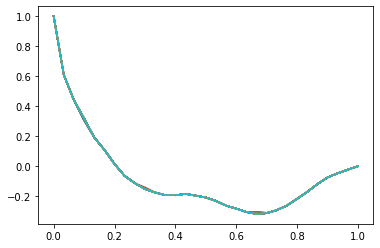

Generation 8000, current best = 0.683, current population size = 40
Population Diagram: 
--------------------------------


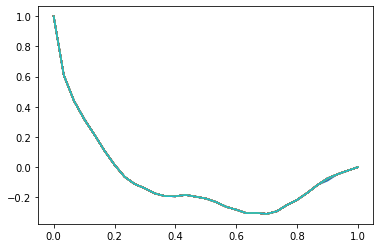

Generation 8500, current best = 0.682, current population size = 40
Population Diagram: 
--------------------------------


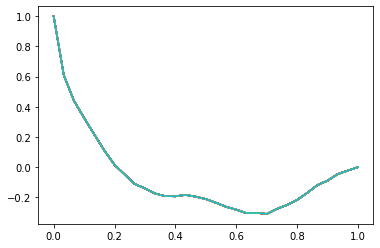

Generation 9000, current best = 0.682, current population size = 40
Population Diagram: 
--------------------------------


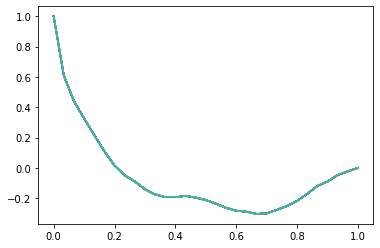

Generation 9500, current best = 0.679, current population size = 40
Population Diagram: 
--------------------------------


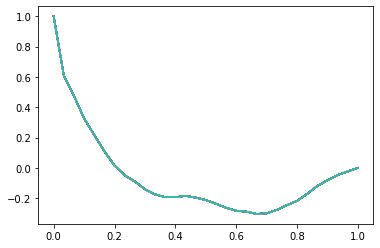

Generation 9999, current best = 0.679, current population size = 40


TypeError: ignored

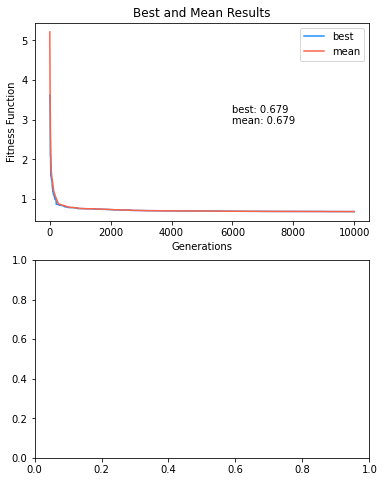

In [52]:
population = Population(Individual, n_individuals, n_points=n_points, height=height)

GeneticAlgorithm(population=population,
                 generations=n_generations,
                 ps=ps,
                 pc=pc,
                 pm=pm)


# Extra